In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import torch.nn as nn
from torch import tensor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
data = np.load('tiny_nerf_data.npz')
images = torch.tensor(data['images'])
poses = torch.tensor(data['poses'])
focalLength = data['focal']

poses[12]
print(images.shape)
print(poses.shape)

width = images.shape[1]
height = images.shape[2]
# plt.imshow(images[10])
# for i in range(0, 100):
#     plt.imsave(f"im2/image{i}.png", images[i])
# poses[1]

torch.Size([106, 100, 100, 3])
torch.Size([106, 4, 4])


In [144]:
numberOfFor = 2
model = nn.Sequential(
	# 3 for the initial x, y,z coordiante
	# then for each fourier feature, one for sin(x), sin(y), sin(z), 
	# and similarily 3 for cos
	nn.Linear(3 + 6*numberOfFor, 300),
	nn.ReLU(),
	nn.Linear(300, 300),
	nn.ReLU(),
	nn.Linear(300, 300),
	nn.ReLU(),
	nn.Linear(300, 300),
	nn.ReLU(),
	# 3 for r, g, b and last one for radiance
	nn.Linear(300, 4),
	nn.Sigmoid(),
)
model  = model.to(device)

In [4]:
# %matplotlib widget

%matplotlib inline

In [79]:
# returns a two tensors, one with shape [width, height, 3] 
# representing the direction of a ray going through each pixel and another [width, height, 3] 
# representing the starting position of that same ray (all of which are the same) since 
# all rays start out at the origin
def getRays(width, height, focalLength, pose):
    xCoords = tensor([x for x in torch.arange(width)])
    yCoords = tensor([y for y in torch.arange(height)])
    x, y = torch.meshgrid(xCoords, yCoords)
    # print(x[55][49])
    # print(y[55][49])

    xShifted = x - width*0.5 # x coords in a [width, height] tensor
    xShifted = nn.functional.normalize(xShifted)

    yShifted = y - height*0.5 # y coords in a [width, height] tensor
    yShifted = nn.functional.normalize(yShifted)

    z = torch.ones_like(x)  # z coords in a [width, height] tensor

    # match up each element of the 3 tensors (thats why using dim = 2)
    directionVectors = torch.stack((xShifted, yShifted, z), dim=2).to(device)
    rotationMatrix = pose[0:3, 0:3]
    rotatedDirections = torch.matmul(directionVectors, rotationMatrix)

    origin =  pose[:3, 2]

    # all the rays have the same origin
    originTensor =  torch.broadcast_to(origin, rotatedDirections.shape)
    return rotatedDirections, originTensor


	# print(directionVectors.shape)
	# print(xShifted[5][0])
	# print(yShifted[5][99])
	# print(x[4][6])
	# print(y[4][6])
dirs, pos = getRays(width, height, focalLength, poses[10].to(device))
print(dirs.shape, pos.shape)
print(dirs[0][0], pos[0][0])


torch.Size([100, 100, 3]) torch.Size([100, 100, 3])
tensor([0.0955, 0.9372, 0.3905], device='cuda:0') tensor([-0.8323, -0.5092,  0.2190], device='cuda:0')


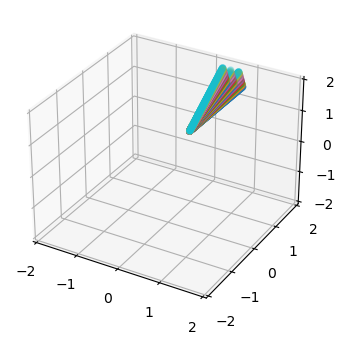

In [80]:
import matplotlib


%matplotlib inline

# matplotlib.use('WebAgg')


numberOfSamples = 50
far = 2
distanceBetweenSamples = 2/50

def get_rays_with_samples(pose):
	dirs, pos = getRays(width, height, focalLength, pose)

	# dirs = (width, height, 3)
	# t = (numberOfSamples)
	# goal = (width, height, numberOfSamples, 3)
	# where goal[x][y][i] = dirs[x][y] * t[i]
	t = torch.linspace(0, far, numberOfSamples).reshape(1, 1, numberOfSamples, 1).to(device)

	# dirs has shape (width, height, 3) right now (a direction for every pixel)
	# We want to instead have a list of numberOfSamples for each pixel, so (width, height, numberOfSamples, 3)
	dirs = dirs.reshape(width, height, 1, 3)
	pos = pos.reshape(width, height, 1, 3)
	z = pos + t*dirs
	z = z.to(device)
	return z

far = 2
def visulize_3D_rays(poseNumber):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(projection='3d')
    rays = get_rays_with_samples(poseNumber)
    with torch.no_grad():
        rays = rays.cpu()
        for i in range(0, width, 10):
            for j in range(0, height, 10):
                step = 1
                ray = rays[i][j][::step]
                ax.scatter(ray[:, 0], ray[:,1], ray[:, 2])
        ax.set_xlim3d([-far, far])
        ax.set_ylim3d([-far, far])
        ax.set_zlim3d([-far, far])
        ax.set_autoscale_on(False)

	# plt.savefig(f"img/{poseNumber}.png")
# for i in range(0, 100):
	# visulize_3D_rays(i)
# visulize_3D_rays(0)
visulize_3D_rays(poses[0].to(device))
# get_rays_with_samples(10).shape


In [166]:
import gc
import math
def get_model_at_each_sample_point(rays):
    # print(rays.shape)
    coord  = rays[0][0][0]
    rawCoord = rays[0][0][0]
    print(coord)
    coord = coord.reshape(3, 1).expand(2, 3, 1)
    twos = torch.tensor(2).repeat(2, 3, numberOfFor) # 2 since one for sin one for cos
    twos[:, 0] = 1
    twos = torch.cumprod(twos, dim=1).to(device)
    ## Twos is a (3, numberOfFor+, 21) shaped where each row is [1, 2, 4, 8, ...]
    encoding = coord*math.pi*twos
    encoding[0] = torch.sin(encoding[0])
    encoding[1] = torch.cos(encoding[1])
    encoding = encoding.flatten()
    print(encoding)
    # add non fourer as well
    encoding = torch.concat((rawCoord, encoding), dim=0)
    print(encoding)

    return model(rays)
    

def get_image(pose):
	gc.collect()
	torch.cuda.empty_cache()
	# current (width, height, numberOfSamples, 4)
	rays = get_rays_with_samples(pose)
	out = get_model_at_each_sample_point(rays)
	# model_out = (width, height, numberOfSamples, 4), where r is rgb + d
	deltaI = tensor(distanceBetweenSamples)

	# Goes from out = (width,height, numberOfSamples, 4) to C = (width, height, 3)

	# The first two dimenstions are width and height
	Ti = torch.cumprod(torch.exp(-out[:, : , :, 3]*deltaI), dim = 2)
	Ti = Ti.reshape(width, height, numberOfSamples, 1)

	aboservedAmounts = (1- torch.exp(-out[:, :, :, 3]*deltaI)).reshape((width, height, numberOfSamples, 1))
	colorI = out[:, :, :, 0:3]

	# Sum along the ray (the first two dimenensions are the width and height)
	C = torch.sum(Ti*aboservedAmounts * colorI, dim = 2)
	return C

# get_image()
def f():
	with torch.no_grad():
		get_image(poses[0].to(device))
f()

tensor([-0.0133,  0.9539,  0.2997], device='cuda:0')
tensor([-0.0419, -0.0419, -0.2854, -0.2854, -0.5846, -0.5846,  0.9991,  0.9991,
         0.9584,  0.9584, -0.8113, -0.8113], device='cuda:0')
tensor([-0.0133,  0.9539,  0.2997, -0.0419, -0.0419, -0.2854, -0.2854, -0.5846,
        -0.5846,  0.9991,  0.9991,  0.9584,  0.9584, -0.8113, -0.8113],
       device='cuda:0')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (500000x3 and 18x300)

cuda:0
cuda:0
torch.Size([100, 100, 50, 1])


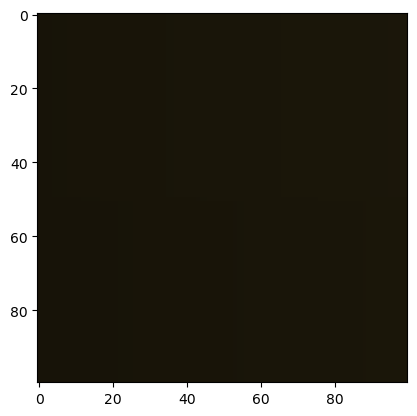

In [65]:
with torch.no_grad():
        pose = poses[0].to(device)
        im = get_image(pose).cpu()
        plt.imshow(im)

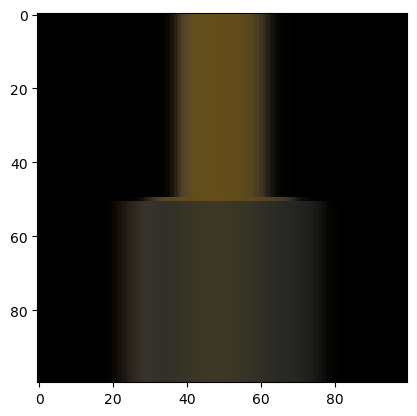

Loss is 0.014993631280958652:   5%|▌         | 523/10000 [02:25<44:01,  3.59it/s]  


KeyboardInterrupt: 

In [76]:
epochs = 10000
from tqdm import tqdm
from IPython.display import clear_output
def loss_fn(output, target):
		loss = torch.mean((output - target)**2)
		return loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

pbar = tqdm(range(epochs))
# pbar = range(epochs)

image_display = None

fig = plt.figure()
ax = fig.gca()
i = 0
for n in pbar: 
    for pose, image in zip(posesGpu[0:1], images[0:1]):
        i += 1
        # print("doing pose", device)
        pose = pose.to(device)
        pred_image = get_image(pose)
        image = image.to(device)
        loss += loss_fn(pred_image, image)
        
        if(i % 25):
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.set_description( f"Loss is {loss}")
            loss = 0

        if(i % 10 == 0):
            print("displaying")
            with torch.no_grad():
                clear_output()
                image  = get_image(pose).cpu()
                plt.imshow(image)
                # if not image_display:
                    # image_display = ax.imshow(image)
                    # image_display = plt.imshow(image)
                    # plt.show()
                # image_display.set_data(image)
                plt.show()
                # fig.canvas.draw()
                # fig.show()
                # image_display.draw()
        


In [ ]:
image  = get_image()
plt.imshow(image)